In [ ]:
import pandas as pd
import numpy as np
import os
import email
import email.policy
import re
from bs4 import BeautifulSoup
import csv
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import sklearn.metrics
import matplotlib.pyplot as plt
from collections import Counter
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import ExtraTreesClassifier

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Creamos el dataset. 

Nuestro directorio es de la siguiente forma:
* /data
  * /ham 
    * fichero_ham1
    * fichero_ham2
    * ...
  * /spam
    * fichero_spam1
    * fichero_spam2
    * ...


In [ ]:
os.listdir('/content/drive/MyDrive/4to año/2do Cuatrimestre/TFG/Materiales/detección de spam/data')

['spam_or_not_spam.csv',
 'ham',
 'spam',
 'spam_ham_dataset_v0.csv',
 'spam_ham_dataset.csv']

Leemos todos los ficheros ham.

In [ ]:
ham_filenames = []
for file in sorted(os.listdir('/content/drive/MyDrive/4to año/2do Cuatrimestre/TFG/Materiales/detección de spam/data/ham')):
  if not file.startswith('.'):
    ham_filenames.append(file)


Leemos todos los ficheros spam.

In [ ]:
spam_filenames = []
for file in sorted(os.listdir('/content/drive/MyDrive/4to año/2do Cuatrimestre/TFG/Materiales/detección de spam/data/spam')):
  if not file.startswith('.'):
    spam_filenames.append(file)

Cantidad de ficheros spam y ham. 

In [ ]:
print('Amount of ham files:', len(ham_filenames))
print('Amount of spam files:', len(spam_filenames))    
print('Spam to Ham Ratio:',len(spam_filenames)/len(ham_filenames))

Amount of ham files: 1100
Amount of spam files: 495
Spam to Ham Ratio: 0.45


Cargamos todos los correos y los guardamos en ham_emails o spam_emails, dependiendo de sí son spam o no. 

In [ ]:
def load_email(is_spam, filename):
    directory = '/content/drive/MyDrive/4to año/2do Cuatrimestre/TFG/Materiales/detección de spam/data/spam' if is_spam else '/content/drive/MyDrive/4to año/2do Cuatrimestre/TFG/Materiales/detección de spam/data/ham'
    with open(os.path.join(directory, filename), "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)
    
ham_emails = [load_email(is_spam=False, filename=name) for name in ham_filenames]
spam_emails = [load_email(is_spam=True, filename=name) for name in spam_filenames]   

Las siguientes funciones son para obtener el contenido del mensaje del email. 

In [ ]:
# email to plain text

def get_email_structure(email):
    if isinstance(email, str):
        return email
    payload = email.get_payload()
    if isinstance(payload, list):
        return "multipart({})".format(", ".join([
            get_email_structure(sub_email)
            for sub_email in payload
        ]))
    else:
        return email.get_content_type()

def structures_counter(emails):
    structures = Counter()
    for email in emails:
        structure = get_email_structure(email)
        structures[structure] += 1
    return structures

In [ ]:
def html_to_plain(email):
    try:
        soup = BeautifulSoup(email.get_content(), 'html.parser')
        return soup.text.replace('\n\n','')
    except:
        return "empty"

In [ ]:
def email_content(email):
    struct = get_email_structure(email)
    for part in email.walk():
        partContentType = part.get_content_type()
        if partContentType not in ['text/plain','text/html']:
            continue
        try:
            partContent = part.get_content()
        except: 
            partContent = str(part.get_payload())
        if partContentType == 'text/plain':
            return partContent
        else:
            return html_to_plain(part)

In [ ]:
def email_to_plain(email):
    struct = get_email_structure(email)
    for part in email.walk():
        partContentType = part.get_content_type()
        if partContentType not in ['text/plain','text/html']:
            continue
        try:
            partContent = part.get_content()
        except: 
            partContent = str(part.get_payload())
        return partContent

Obtener las 10 palabras que más se repiten en los ficheros spam

In [ ]:
import nltk
import re
nltk.download('stopwords')
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
stopw = stopwords.words('english')

for word in stopwords.words('english'):
  stopw.append(word.capitalize())

stopw.extend(['http', 'www', 'com', 'a', 'A', 'e', 'E', 'i', 'o', 'O', 'u', 'U', 'mail'])

In [ ]:
def read_words(email):
  email = email_content(email) 
  email = re.sub('[^a-zA-Z]', ' ', email) 
  text = email.split()
  [words.append(word) for word in text if not word in stopw]      

In [ ]:
words = []
[read_words(spam) for spam in spam_emails]
word_counts = Counter(words)
print(word_counts)

Counter({'money': 454, 'email': 421, 'FREE': 361, 'people': 352, 'one': 310, 'information': 308, 'list': 307, 'time': 306, 'get': 303, 'business': 272, 'make': 257, 'send': 257, 'receive': 254, 'l': 253, 'please': 245, 'TO': 235, 'us': 232, 'address': 225, 'name': 214, 'THE': 212, 'YOU': 208, 'p': 207, 'free': 204, 'de': 197, 'OF': 188, 'Please': 186, 'wish': 176, 'new': 173, 'YOUR': 173, 'home': 168, 'also': 168, 'program': 167, 'click': 166, 'made': 165, 'may': 163, 'want': 162, 'NOT': 160, 'would': 160, 'like': 157, 'AND': 156, 'ie': 156, 'company': 156, 'r': 156, 'Click': 155, 'work': 154, 'net': 153, 'Free': 149, 'need': 149, 'linux': 148, 'go': 148, 'day': 147, 'message': 146, 'received': 139, 'government': 139, 'use': 138, 'form': 137, 'removed': 136, 'font': 136, 'P': 135, 'remove': 133, 'NOW': 131, 'R': 130, 'Internet': 126, 'year': 126, 'link': 125, 'sent': 125, 'mails': 124, 'today': 123, 'x': 122, 'f': 122, 'help': 121, 'Report': 120, 'right': 118, 'family': 116, 'C': 116, 

In [ ]:
common_words = []
for i in range(10):
  common_words.append(word_counts.most_common()[i][0])

In [ ]:
print(common_words)

['money', 'email', 'FREE', 'people', 'one', 'information', 'list', 'time', 'get', 'business']


Función para construir el dataset

In [ ]:
def read_data(email, target):
  data = [] 
  
  # 1. Longitud del asunto:
  data.append(len(email['Subject']))

  # 2. Número de destinatarios
  if not email['To'] :
    data.append(0)
  else : 
    data.append(len(email['To'].split(',')))

  # 3. Hora (formato 24h)
  data.append(int(email['Date'].split(' ')[4].split(':')[0]))

  email = email_to_plain(email) 

  # 4. Longitud del texto
  data.append(len(email))

  # 5. Número de símbolos del $
  dollars = re.findall("\$", email)
  if not dollars :
    data.append(0)
  else :
    data.append(len(dollars))

  # 6. Número de símbolos del €
  euros = re.findall("\€", email)
  if not euros :
    data.append(0)
  else :
    data.append(len(euros))

  # 7. Número de símbolos del %
  percent = re.findall("\%", email)
  if not percent :
    data.append(0)
  else :
    data.append(len(percent))

  # 8. Número de URLs
  data.append(len(re.findall('(http?://\S+)', email)))

  # 9. Número de símbolos de exclamación
  exclamation = re.findall("!", email)
  if not exclamation :
    data.append(0)
  else :
    data.append(len(exclamation))
  
  # Las 10 palabras más comunes.
  email = re.sub('[^a-zA-Z].<.>', ' ', email) 
  text = email.split()
  word_counts = Counter(text)
  for i in range(10):
    data.append(word_counts[common_words[i]])

  # Si tiene contenido html
  if word_counts['<!DOCTYPE'] or word_counts['<html>'] or word_counts['<meta'] or word_counts['<head>'] or word_counts['<body>']:
    data.append(1)
  else:
    data.append(0)

  # etiqueta  
  data.append(target)

  return data


****************************************************************************************************

Construimos el dataset:

In [ ]:
dataset = [['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11', 
            'F12', 'F13', 'F14', 'F15', 'F16', 'F17', 'F18', 'F19', 'F20', 'F21'
            ]]

for spam in spam_emails:
  data = read_data(spam, 1)
  dataset.append(data)

for ham in ham_emails:
  data = read_data(ham, 0)
  dataset.append(data)


In [ ]:
print(dataset)

[['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11', 'F12', 'F13', 'F14', 'F15', 'F16', 'F17', 'F18', 'F19', 'F20', 'F21'], [30, 1, 20, 3668, 0, 0, 8, 1, 9, 0, 1, 2, 0, 0, 0, 0, 0, 1, 0, 1, 1], [53, 1, 6, 781, 0, 0, 2, 7, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1], [71, 1, 7, 625, 0, 0, 2, 6, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1], [76, 1, 8, 2904, 0, 0, 0, 6, 16, 0, 1, 2, 0, 3, 0, 0, 0, 2, 0, 0, 1], [64, 1, 9, 659, 0, 0, 2, 5, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1], [34, 1, 10, 2411, 10, 0, 0, 0, 26, 0, 3, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1], [41, 1, 13, 692, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1], [25, 1, 10, 29663, 0, 0, 41, 13, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1], [55, 1, 12, 2849, 14, 0, 0, 0, 55, 0, 4, 3, 1, 0, 1, 1, 0, 1, 0, 0, 1], [28, 4, 13, 2238, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1], [70, 1, 15, 760, 1, 0, 0, 3, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [50, 1, 8, 804, 0, 0, 0, 3, 6, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1], [67, 1, 15, 625, 0, 0,

Generamos un fichero .csv con el dataset que hemos creado. 

In [ ]:
with open('spam_ham_dataset.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    for row in dataset: 
      writer.writerow(row)


----------------------------------------------------------------------------------------------------------------------------------------------------------



Cargamos nuestro dataset:

In [ ]:
df = pd.read_csv("/content/spam_ham_dataset.csv")
df.head(8)

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21
0,30,1,20,3668,0,0,8,1,9,0,1,2,0,0,0,0,0,1,0,1,1
1,53,1,6,781,0,0,2,7,2,0,0,0,0,0,0,1,0,0,0,0,1
2,71,1,7,625,0,0,2,6,2,0,0,0,0,0,0,1,0,0,0,0,1
3,76,1,8,2904,0,0,0,6,16,0,1,2,0,3,0,0,0,2,0,0,1
4,64,1,9,659,0,0,2,5,1,0,0,0,0,0,0,1,0,0,0,0,1
5,34,1,10,2411,10,0,0,0,26,0,3,1,1,0,0,1,0,1,0,0,1
6,41,1,13,692,0,0,0,2,0,0,0,0,0,1,0,0,0,0,0,0,1
7,25,1,10,29663,0,0,41,13,0,0,1,0,0,0,0,0,0,0,0,1,1


Si el dataset se tiene almacenado en otro directorio:

In [ ]:
## Trabajamos ahora con los datos ya procesados
df = pd.read_csv("/content/drive/MyDrive/4to año/2do Cuatrimestre/TFG/Materiales/detección de spam/data/spam_ham_dataset.csv")
df.head(8)

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21
0,30,1,20,3668,0,0,8,1,9,0,1,2,0,0,0,0,0,1,0,1,1
1,53,1,6,781,0,0,2,7,2,0,0,0,0,0,0,1,0,0,0,0,1
2,71,1,7,625,0,0,2,6,2,0,0,0,0,0,0,1,0,0,0,0,1
3,76,1,8,2904,0,0,0,6,16,0,1,2,0,3,0,0,0,2,0,0,1
4,64,1,9,659,0,0,2,5,1,0,0,0,0,0,0,1,0,0,0,0,1
5,34,1,10,2411,10,0,0,0,26,0,3,1,1,0,0,1,0,1,0,0,1
6,41,1,13,692,0,0,0,2,0,0,0,0,0,1,0,0,0,0,0,0,1
7,25,1,10,29663,0,0,41,13,0,0,1,0,0,0,0,0,0,0,0,1,1


In [ ]:
df.F21.value_counts()

# 0 -> ham
# 1 -> spam

0    1100
1     495
Name: F21, dtype: int64

Indicamos las variables predictoras y debajo la variable objetivo.

In [ ]:
predictors = df[['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 
                 'F11', 'F12','F13', 'F14', 'F15', 'F16', 'F17', 'F18', 'F19', 'F20'
                 ]]

target = df.F21

In [ ]:
target.unique()

array([1, 0])

Creamos la muestra de entrenamiento y de test, tanto para predictores como para la variable objetivo, siendo test el 20%

In [ ]:
pred_train, pred_test, tar_train, tar_test = train_test_split(predictors, target,  test_size=.2)

En este caso probaremos con varios algoritmos de aprendizaje supervisado para ver cuál obtiene mejores resultados.

**Random Forest**

In [ ]:
classifier=RandomForestClassifier()

In [ ]:
#Construimos el modelo sobre los datos de entrenamiento
classifier = classifier.fit(pred_train, tar_train)


CONFUSION MATRIX


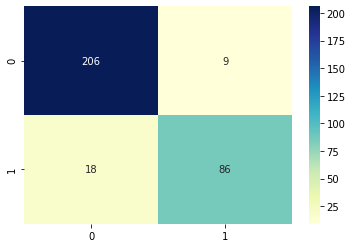

In [ ]:
#Predecimos para los valores del grupo Test
predictions=classifier.predict(pred_test)

# creating confusing matrix
from sklearn.metrics import confusion_matrix
con_mat = confusion_matrix(tar_test,predictions)


print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")


In [ ]:
#Sacamos el índice Accuracy Score, que resume la Matriz de Confusión y la cantidad de aciertos.
print("Random Forest (1). Accuracy Score:" , sklearn.metrics.accuracy_score(tar_test, predictions))

Random Forest (1). Accuracy Score: 0.9153605015673981


In [ ]:
#Para obtener la importancia de cada variable inicializamos el  ExtraTreesClassifier
model = ExtraTreesClassifier()

#Ajustamos el modelo
model.fit(pred_train,tar_train)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

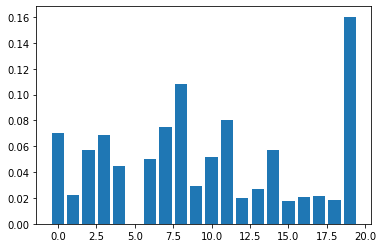

In [ ]:
#Para dibujar todos las variables con su importancia
from matplotlib import pyplot
pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
pyplot.show()

Lo hacemos ahora teniendo en cuenta solo las variables más importantes:


CONFUSION MATRIX


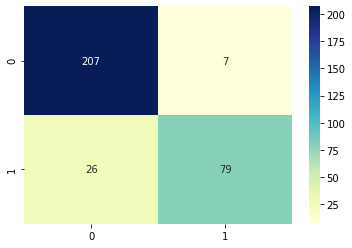

In [ ]:
predictors = df[['F1', 'F3', 'F4', 'F5', 'F7', 'F8', 'F9', 'F11', 'F12', 'F15', 'F20']]

target = df.F21
target.unique()

pred_train, pred_test, tar_train, tar_test = train_test_split(predictors, target,  test_size=.2)

classifier = RandomForestClassifier(n_estimators=10)

classifier = classifier.fit(pred_train, tar_train)

predictions=classifier.predict(pred_test)

from sklearn.metrics import confusion_matrix
con_mat = confusion_matrix(tar_test,predictions)

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

In [ ]:
#Sacamos el índice Accuracy Score
print("Random Forest (2). Accuracy Score: " , sklearn.metrics.accuracy_score(tar_test, predictions))

Random Forest (2). Accuracy Score:  0.896551724137931


In [ ]:
-----------------------------------------------------------------------------------------------------------------------------------

**NAIVE BAYES**

In [ ]:
## Naive Bayes
predictors = df[['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11', 'F12',
                 'F13', 'F14', 'F15', 'F16', 'F17', 'F18', 'F19', 'F20']]

target = df.F21
target.unique()

#Creamos la muestra de entrenamiento y de test, tanto para predictores como para la variable objetivo, siendo test el 20%
pred_train, pred_test, tar_train, tar_test = train_test_split(predictors, target,  test_size=.2)

classifier = MultinomialNB()

In [ ]:
# Construimos el modelo
classifier = classifier.fit(pred_train, tar_train)

In [ ]:
#Predecimos para los valores del grupo Test
predictions=classifier.predict(pred_test)


CONFUSION MATRIX


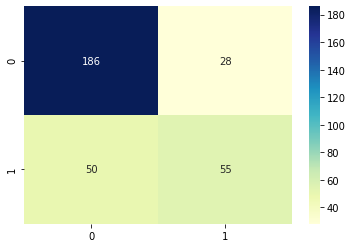

In [ ]:
# creating confusing matrix
from sklearn.metrics import confusion_matrix
con_mat = confusion_matrix(tar_test,predictions)


print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

In [ ]:
#Sacamos el índice Accuracy Score, que resume la Matriz de Confusión y la cantidad de aciertos.
print("Naive Bayes (1). Accuracy Score: " , sklearn.metrics.accuracy_score(tar_test, predictions))

Naive Bayes (1). Accuracy Score:  0.7554858934169278


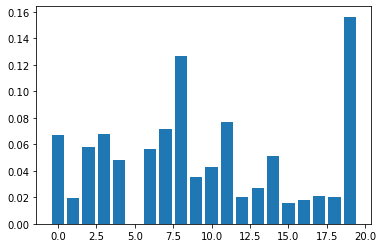

In [ ]:
#Para obtener la importancia de cada variable inicializamos el  ExtraTreesClassifier
model = ExtraTreesClassifier()

#Ajustamos el modelo
model.fit(pred_train,tar_train)

#Para dibujar todos las variables con su importancia
from matplotlib import pyplot
pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
pyplot.show()


CONFUSION MATRIX


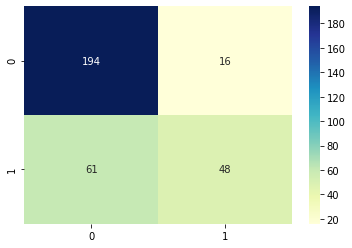

In [ ]:
predictors = df[['F1', 'F3', 'F4', 'F5', 'F7', 'F8', 'F9', 'F11', 'F12', 'F15', 'F20']]

target = df.F21
target.unique()

pred_train, pred_test, tar_train, tar_test = train_test_split(predictors, target,  test_size=.2)

classifier = MultinomialNB()

classifier = classifier.fit(pred_train, tar_train)

predictions=classifier.predict(pred_test)

# creating confusing matrix
from sklearn.metrics import confusion_matrix
con_mat = confusion_matrix(tar_test,predictions)


print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

In [ ]:
#Sacamos el índice Accuracy Score
print("Naive Bayes (2). Accuracy Score: " , sklearn.metrics.accuracy_score(tar_test, predictions))

Naive Bayes (2). Accuracy Score:  0.7586206896551724


**Regresión logística**

In [ ]:
# regresión logística
predictors = df[['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11', 'F12',
                 'F13', 'F14', 'F15', 'F16', 'F17', 'F18', 'F19', 'F20']]

target = df.F21
target.unique()

#Creamos la muestra de entrenamiento y de test, tanto para predictores como para la variable objetivo, siendo test el 20%
pred_train, pred_test, tar_train, tar_test = train_test_split(predictors, target,  test_size=.2)

classifier = LogisticRegression(solver="liblinear")

In [ ]:
# Construimos el modelo
classifier = classifier.fit(pred_train, tar_train)

In [ ]:
predictions=classifier.predict(pred_test)


CONFUSION MATRIX


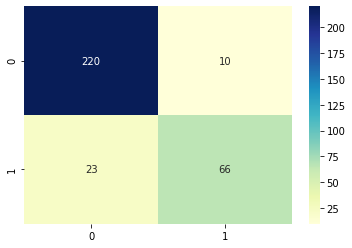

In [ ]:
con_mat = confusion_matrix(tar_test,predictions)


print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

In [ ]:
#Sacamos el índice Accuracy Score, que resume la Matriz de Confusión y la cantidad de aciertos.
print("Regresión logística (1). Accuracy Score: " , sklearn.metrics.accuracy_score(tar_test, predictions))

Regresión logística (1). Accuracy Score:  0.896551724137931


0.890282131661442


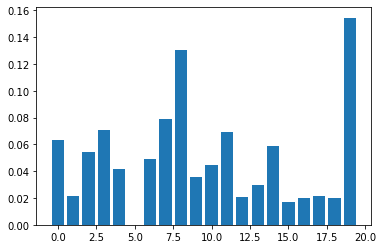

In [ ]:
#Para obtener la importancia de cada variable inicializamos el  ExtraTreesClassifier
model = ExtraTreesClassifier()

#Ajustamos el modelo
model.fit(pred_train,tar_train)

#Para dibujar todos las variables con su importancia
from matplotlib import pyplot
pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
pyplot.show()


CONFUSION MATRIX


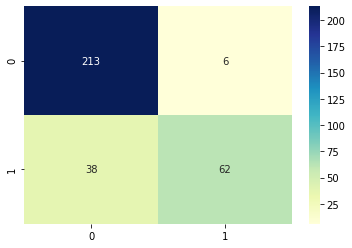

In [ ]:
# Ahora con las tres últimas variables:
predictors = df[['F1', 'F3', 'F4', 'F5', 'F7', 'F8', 'F9', 'F11', 'F12', 'F15', 'F20']]

target = df.F21
target.unique()

#Creamos la muestra de entrenamiento y de test, tanto para predictores como para la variable objetivo, siendo test el 20%
pred_train, pred_test, tar_train, tar_test = train_test_split(predictors, target,  test_size=.2)

classifier = LogisticRegression(solver="liblinear")

classifier = classifier.fit(pred_train, tar_train)

#Predecimos para los valores del grupo Test
predictions=classifier.predict(pred_test)

# creating confusing matrix
from sklearn.metrics import confusion_matrix
con_mat = confusion_matrix(tar_test,predictions)


print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

In [ ]:
#Sacamos el índice Accuracy Score, que resume la Matriz de Confusión y la cantidad de aciertos.
print("Regresión logística (2). Accuracy Score: " , sklearn.metrics.accuracy_score(tar_test, predictions))

Regresión logística (2). Accuracy Score:  0.8620689655172413
